Import necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from tensorflow.keras.utils import plot_model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
from keras.models import Model
from copy import copy
from math import log
import math

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_file = '/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
val_file   = '/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
test_file  = '/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

Preprocess data

In [ ]:
def processData(filename, input_chars=None, target_chars=None):
    """
    Loads and processes parallel text data for a sequence-to-sequence model.

    Args:
        filename (str): Path to the tab-separated data file.
        input_chars (set, optional): Set of unique characters from the input language.
                                     If None, a new set is created.
        target_chars (set, optional): Set of unique characters from the target language.
                                      If None, a new set is created.

    Returns:
        input_texts (List[str]): List of input sentences (Latin script).
        target_texts (List[str]): List of target sentences (Native script), wrapped with \t and \n.
        input_chars (List[str]): Sorted list of unique characters in input.
        target_chars (List[str]): Sorted list of unique characters in output.
        num_encoder_tokens (int): Number of unique characters in input.
        num_decoder_tokens (int): Number of unique characters in output.
        max_encoder_seq_length (int): Maximum length of input sequences.
        max_decoder_seq_length (int): Maximum length of output sequences.
    """

    # Initialize sets if not provided
    if input_chars is None:
        input_chars = set()
    if target_chars is None:
        target_chars = set()

    input_texts = []
    target_texts = []

    # Read and split file into lines
    with open(filename, "r", encoding="utf-8") as f:
        lines = f.read().strip().split("\n")

    for line in lines:
        try:
            native_script, latin_script, attestation = line.split("\t")
        except ValueError:
            # Skip lines that don't have exactly 3 tab-separated fields
            continue

        # Add raw input (Latin script)
        input_texts.append(latin_script)

        # Add target text wrapped with start (\t) and end (\n) tokens
        target_texts.append("\t" + native_script + "\n")

        # Update character sets
        input_chars.update(latin_script)
        target_chars.update(native_script)

    # Add start and end tokens to target character set
    target_chars.update(["\t", "\n"])

    # Sort characters to keep token indices consistent
    input_chars = sorted(input_chars)
    target_chars = sorted(target_chars)

    # Count unique characters
    num_encoder_tokens = len(input_chars)
    num_decoder_tokens = len(target_chars)

    # Find max sequence lengths
    max_encoder_seq_length = max(len(txt) for txt in input_texts)
    max_decoder_seq_length = max(len(txt) for txt in target_texts)

    return (
        input_texts,
        target_texts,
        input_chars,
        target_chars,
        num_encoder_tokens,
        num_decoder_tokens,
        max_encoder_seq_length,
        max_decoder_seq_length,
    )




Preprocess train data

In [ ]:
input_texts, target_texts, input_chars, target_chars, num_encoder_tokens, num_decoder_tokens, max_input_len, max_target_len = processData(train_file)

assert len(input_texts) == len(target_texts), "Mismatch between input and target samples."

print(f"Number of samples: {len(input_texts)}")
print(f"Unique input tokens: {num_encoder_tokens}")
print(f"Unique output tokens: {num_decoder_tokens}")
print(f"Max input length: {max_input_len}")
print(f"Max output length: {max_target_len}")


Number of samples: 44204
Unique input tokens: 26
Unique output tokens: 65
Max input length: 20
Max output length: 21


Preprocess Validation data

In [ ]:
val_input, val_target, input_chars, target_chars, num_encoder_tokens, num_decoder_tokens, val_max_encoder_seq_length, val_max_decoder_seq_length = processData(
    val_file, set(input_chars), set(target_chars)
)

# Recompute token counts in case new characters were added from val set
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)

# Sanity checks
print(f"Number of validation samples: {len(val_input)}")
print(f"Unique input tokens (updated): {num_encoder_tokens}")
print(f"Unique output tokens (updated): {num_decoder_tokens}")
print(f"Max val input length: {val_max_encoder_seq_length}")
print(f"Max val output length: {val_max_decoder_seq_length}")


Number of validation samples: 4358
Unique input tokens (updated): 26
Unique output tokens (updated): 65
Max val input length: 18
Max val output length: 16


Preprocess test data

In [ ]:
test_input, test_target, test_input_chars, test_target_chars, test_num_encoder_tokens, test_num_decoder_tokens, test_max_encoder_seq_length, test_max_decoder_seq_length = processData(
    test_file, set(input_chars), set(target_chars)
)

# Optionally update token counts (if any new chars in test)
test_num_encoder_tokens = len(input_chars)
test_num_decoder_tokens = len(target_chars)

print(f"Number of test samples: {len(test_input)}")
print(f"Test Max sequence length for inputs: {test_max_encoder_seq_length}")
print(f"Test Max sequence length for outputs: {test_max_decoder_seq_length}")


Number of test samples: 4502
Test Max sequence length for inputs: 16
Test Max sequence length for outputs: 17


Seq2Seq Character-Level One-Hot Encoding for Train, Validation, and Test Data

In [ ]:
# Token-to-index dictionaries for input and target characters
input_token_index = {char: i for i, char in enumerate(input_chars)}
target_token_index = {char: i for i, char in enumerate(target_chars)}

# Reverse dictionaries for decoding (index-to-char)
reverse_input_token_index = {i: char for char, i in input_token_index.items()}
reverse_target_token_index = {i: char for char, i in target_token_index.items()}

# Initialize encoder and decoder input/output arrays with zeros
encoder_input_data = np.zeros(
    (len(input_texts), max_input_len, num_encoder_tokens), dtype="float32"
)
val_encoder_input_data = np.zeros(
    (len(val_input), max_input_len, num_encoder_tokens), dtype="float32"
)
test_encoder_input_data = np.zeros(
    (len(test_input), max_input_len, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(input_texts), max_target_len, num_decoder_tokens), dtype="float32"
)
val_decoder_input_data = np.zeros(
    (len(val_input), max_target_len, num_decoder_tokens), dtype="float32"
)
test_decoder_input_data = np.zeros(
    (len(test_input), max_target_len, num_decoder_tokens), dtype="float32"
)

decoder_target_data = np.zeros(
    (len(input_texts), max_target_len, num_decoder_tokens), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input), max_target_len, num_decoder_tokens), dtype="float32"
)
test_decoder_target_data = np.zeros(
    (len(test_input), max_target_len, num_decoder_tokens), dtype="float32"
)

# Vectorize training data
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        # decoder_target_data is one timestep ahead and excludes start char "\t"
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Vectorize validation data
for i, (input_text, target_text) in enumerate(zip(val_input, val_target)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        val_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

# Vectorize test data
for i, (input_text, target_text) in enumerate(zip(test_input, test_target)):
    for t, char in enumerate(input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        test_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            test_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0


Beam search decoder and translation function

In [ ]:

def beam_search_decoder(probabilities, k):
    """
    Perform beam search decoding.

     Args:
        probabilities: A list of softmax outputs for each time step (list of lists).
        k: Beam width.

    Returns:
        A list of top k decoded sequences with their scores.
    """
    decoded_sequences = [[[], 0.0]]  # Each item: (token index sequence, log-prob score)

    # Iterate over each time step
    for timestep_probs in probabilities:
        candidates = []
        for sequence, score in decoded_sequences:
            for token_index, token_prob in enumerate(timestep_probs):
                candidate_seq = sequence + [token_index]
                candidate_score = score - log(token_prob + 1e-10)  # Avoid log(0)
                candidates.append([candidate_seq, candidate_score])

        # Keep top k sequences with lowest negative log-prob (i.e., highest prob)
        decoded_sequences = sorted(candidates, key=lambda x: x[1])[:k]

    return decoded_sequences


def translate(token_index_sequence):
    """
    Convert a sequence of token indices to the corresponding target text.

    Args:
        token_index_sequence: A list of integer indices representing target tokens.

    Returns:
        A decoded string from the target vocabulary.
    """
    return ''.join([reverse_target_token_index[idx] for idx in token_index_sequence]).strip()


Beam Search Word-Level Accuracy Evaluation

In [ ]:
class WordAccuracyCallback(keras.callbacks.Callback):
    """
    Custom Keras Callback to compute word-level accuracy using beam search
    at the end of each training epoch.
    """

    def __init__(self, beam_size):
        super().__init__()
        self.beam_size = beam_size

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        # Predict the entire validation set
        predictions = self.model.predict([val_encoder_input_data, val_decoder_input_data])
        correct_count = 0

        # Iterate over each validation sample
        for i in range(predictions.shape[0]):
            # Decode predictions using beam search
            candidate_sequences = beam_search_decoder(predictions[i], self.beam_size)

            # Compare beam search outputs to ground truth
            for j in range(self.beam_size):
                predicted_text = translate(candidate_sequences[j][0][:len(val_target[i]) - 1])
                if "\t" + predicted_text == val_target[i]:  # Include start token for exact match
                    correct_count += 1
                    break  # Only one correct prediction is enough

        # Compute word-level accuracy (rounded to 4 decimal places)
        accuracy = correct_count / predictions.shape[0]
        logs["WordAccuracy"] = round(accuracy, 4)
        print("- WordAccuracy:", logs["WordAccuracy"])


**Sequence-to-Sequence Model with Beam Search Inference**

In [57]:

# Define a custom Seq2Seq model class
class Seq2SeqModel:
    def __init__(self, num_encoder_layers, num_decoder_layers, latent_dim,
                 dropout, recurrent_dropout, cell_type, beam_size):
        """
        Initialize hyperparameters and model components.
        """
        self.model = None
        self.encoder_inputs = None
        self.encoder_states = None
        self.decoder_inputs = None
        self.output_layers = []         # Store decoder layers for inference
        self.decoder_dense = None       # Final output Dense layer for decoder

        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.latent_dim = latent_dim
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.cell_type = cell_type      # LSTM, GRU, or RNN
        self.beam_size = beam_size

        self.encoder_model = None       # Inference encoder model
        self.decoder_model = None       # Inference decoder model

    def build_and_train(self, encoder_input_data, decoder_input_data, decoder_target_data,
                        epochs, batch_size, val_encoder_input_data, val_decoder_input_data,
                        val_decoder_target_data, num_encoder_tokens, num_decoder_tokens):
        """
        Build and train the seq2seq model using training and validation data.
        """
        # ===== ENCODER =====
        self.encoder_inputs = Input(shape=(None, num_encoder_tokens))
        x = self.encoder_inputs

        encoder_states = []

        # Build encoder layers
        for i in range(self.num_encoder_layers):
            return_seq = i < self.num_encoder_layers - 1  # Only return sequences if more layers remain

            if self.cell_type == "LSTM":
                x, state_h, state_c = LSTM(self.latent_dim, return_state=True, return_sequences=return_seq,
                                           dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)(x)
                encoder_states.append((state_h, state_c))
            elif self.cell_type == "GRU":
                x, state_h = GRU(self.latent_dim, return_state=True, return_sequences=return_seq,
                                 dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)(x)
                encoder_states.append(state_h)
            elif self.cell_type == "RNN":
                x, state_h = SimpleRNN(self.latent_dim, return_state=True, return_sequences=return_seq,
                                       dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)(x)
                encoder_states.append(state_h)

        # ===== DECODER =====
        self.decoder_inputs = Input(shape=(None, num_decoder_tokens))
        x = self.decoder_inputs

        self.output_layers = []

        for i in range(self.num_decoder_layers):
            if self.cell_type == "LSTM":
                state_h, state_c = encoder_states[i]
                layer = LSTM(self.latent_dim, return_sequences=True, return_state=True,
                             dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)
                x, _, _ = layer(x, initial_state=[state_h, state_c])
            elif self.cell_type == "GRU":
                state_h = encoder_states[i]
                layer = GRU(self.latent_dim, return_sequences=True, return_state=True,
                            dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)
                x, _ = layer(x, initial_state=[state_h])
            elif self.cell_type == "RNN":
                state_h = encoder_states[i]
                layer = SimpleRNN(self.latent_dim, return_sequences=True, return_state=True,
                                  dropout=self.dropout, recurrent_dropout=self.recurrent_dropout)
                x, _ = layer(x, initial_state=[state_h])

            self.output_layers.append(layer)

        # Output layer to predict the next token
        self.decoder_dense = Dense(num_decoder_tokens, activation='softmax')
        decoder_outputs = self.decoder_dense(x)

        # Compile full model for training
        self.model = Model([self.encoder_inputs, self.decoder_inputs], decoder_outputs)
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        # callback for logging
        callbacks = [WordAccuracyCallback(self.beam_size), WandbMetricsLogger(log_freq="epoch")]

        # Train the model
        self.model.fit(
            [encoder_input_data, decoder_input_data],
            decoder_target_data,
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True,
            validation_data=([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data),
            callbacks=callbacks,
            verbose=1
        )

        # Flatten encoder_states to use in inference
        if self.cell_type == "LSTM":
            self.encoder_states = [s for pair in encoder_states for s in pair]
        else:
            self.encoder_states = encoder_states

    def load_inference_models(self):
        """
        Build separate inference models for encoder and decoder.
        """
        # Encoder model for inference
        self.encoder_model = keras.Model(self.encoder_inputs, self.encoder_states)

        # Decoder inference model
        decoder_state_inputs = []
        x = self.decoder_inputs
        decoder_states = []

        for i in range(self.num_decoder_layers):
            if self.cell_type == "LSTM":
                # Create new input tensors for decoder initial states
                state_input_h = Input(shape=(self.latent_dim,))
                state_input_c = Input(shape=(self.latent_dim,))
                layer = self.output_layers[i]
                x, out_h, out_c = layer(x, initial_state=[state_input_h, state_input_c])
                decoder_state_inputs.extend([state_input_h, state_input_c])
                decoder_states.extend([out_h, out_c])
            else:
                state_input_h = Input(shape=(self.latent_dim,))
                layer = self.output_layers[i]
                x, out_h = layer(x, initial_state=[state_input_h])
                decoder_state_inputs.append(state_input_h)
                decoder_states.append(out_h)

        # Final decoder model for inference
        decoder_outputs = self.decoder_dense(x)
        self.decoder_model = Model([self.decoder_inputs] + decoder_state_inputs,
                                   [decoder_outputs] + decoder_states)

    def decode_sequence(self, input_seq):
        """
        Greedy decoding to generate a sequence from input using inference models.
        """
        # Encode input
        states = self.encoder_model.predict(input_seq)

        # Initialize target sequence with start token
        target_seq = np.zeros((1, 1, self.decoder_dense.units))
        # '\t' is the start-of-sequence character.
        # Check if '\t' is in target_token_index before accessing.
        if '\t' in target_token_index:
            target_seq[0, 0, target_token_index['\t']] = 1.
        else:
            # Handle the case where '\t' is not in the vocabulary
            print("Warning: Start-of-sequence token '\\t' not found in target_token_index.")
            # You might want to raise an error or use a default behavior here
            return "" # Return empty string or handle appropriately

        decoded = []

        while True:
            # Predict next token and get new states
            output_tokens_and_states = self.decoder_model.predict([target_seq] + states)
            output_tokens, states = output_tokens_and_states[0], output_tokens_and_states[1:]

            # Sample a token (greedy search)
            token_index = np.argmax(output_tokens[0, 0])
            # Check if token_index is in reverse_target_token_index before accessing.
            if token_index in reverse_target_token_index:
                char = reverse_target_token_index[token_index]
                decoded.append(char)
            else:
                # Handle the case where the predicted token index is out of bounds
                print(f"Warning: Predicted token index {token_index} not found in reverse_target_token_index.")
                # You might want to break the loop or use a placeholder character
                break


            # Exit condition: either hit max length or find stop character.
            # Check if '\n' is in decoded list.
            if '\n' in decoded or len(decoded) > max_target_len:
                break

            # Update the target sequence (of length 1) with the sampled token.
            target_seq = np.zeros((1, 1, self.decoder_dense.units))
            # Check if char is in target_token_index before accessing.
            if char in target_token_index:
                target_seq[0, 0, target_token_index[char]] = 1.
            else:
                # Handle the case where the character is not in the vocabulary
                print(f"Warning: Character '{char}' not found in target_token_index.")
                # You might want to break the loop or use a placeholder
                break

        return "".join(decoded)

    def get_predictions(self, input_data, target_texts):
        """
        Generate predictions for a batch and compute word-level accuracy.
        """
        correct = 0
        predictions = []

        for i in range(len(input_data)):
            input_seq = input_data[i:i + 1]
            decoded_seq = self.decode_sequence(input_seq)

            if decoded_seq.endswith('\n'):
                decoded_seq = decoded_seq[:-1]

            predictions.append(decoded_seq)
            true_word = target_texts[i][1:-1]  # Remove start and end tokens
            correct += (decoded_seq == true_word)

        accuracy = correct / len(input_data)
        return accuracy, predictions


In [ ]:
 !pip install wandb

In [ ]:
import wandb
wandb.login()

True

In [ ]:
from wandb.integration.keras import WandbMetricsLogger

In [ ]:
sweep_config = {
  'name': 'RNN',
  'method': 'bayes',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'
    },

  'early_terminate': {
        'type': 'hyperband',
        'min_iter': 3,
        'max_iter': 20,
        's': 2
    },

  'parameters': {
        'epochs':{
            'values':[10, 20, 30]
        },
        'batch_size':{
            'values':[32, 64, 128]
        },
        'encoder_layers':{
            'values':[1, 2, 3]
        },
        'decoder_layers':{
            'values':[1, 2, 3]
        },
        'hidden_layer_size':{
            'values':[16, 32, 64, 256]
        },
        'cell_type':{
            'values':['GRU', 'LSTM','RNN']
        },
        'dropout':{
            'values':[0, 0.2, 0.3]
        },
        'recurrent_dropout':{
            'values':[0, 0.2, 0.3]
        },
        'beam_size':{
            'values':[1, 3, 5]
        }

    }

}



In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'DL_Assignment3 without attention', entity = 'me21b118-iit-madras' )

Create sweep with ID: l17agojd
Sweep URL: https://wandb.ai/me21b118-iit-madras/DL_Assignment3%20without%20attention/sweeps/l17agojd


In [ ]:
sweep_id = 'in4rwmxd'
# Sweep training function
def train():
    run = wandb.init()                               # start a W&B run
    cfg = run.config                                 # easier alias

    # Sanity‑check: encoder layers must be ≥ decoder layers
    if cfg.encoder_layers < cfg.decoder_layers:
        print("decoder_layers exceeds encoder_layers; skipping this run.")
        return

    # Build & train the model
    seq2seq = Seq2SeqModel(
        num_encoder_layers=cfg.encoder_layers,
        num_decoder_layers=cfg.decoder_layers,
        latent_dim        =cfg.hidden_layer_size,
        dropout           =cfg.dropout,
        recurrent_dropout =cfg.recurrent_dropout,
        cell_type         =cfg.cell_type,
        beam_size         =cfg.beam_size,
    )

    seq2seq.build_and_train(
        encoder_input_data,
        decoder_input_data,
        decoder_target_data,
        epochs      =cfg.epochs,           # pull from sweep config
        batch_size  =cfg.batch_size,       # pull from sweep config
        val_encoder_input_data =val_encoder_input_data,
        val_decoder_input_data =val_decoder_input_data,
        val_decoder_target_data=val_decoder_target_data,
        num_encoder_tokens     =num_encoder_tokens,
        num_decoder_tokens     =num_decoder_tokens
    )

    run.finish()        # ensures W&B properly closes the run

# Kick off the sweep agent
wandb.agent(sweep_id=sweep_id, function=train, count=7)



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwqtscm4 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.2
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	recurrent_dropout: 0.2


decoder_layers exceeds encoder_layers; skipping this run.


wandb: Agent Starting Run: glp719d4 with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	epochs: 30
wandb: 	hidden_layer_size: 32
wandb: 	recurrent_dropout: 0


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.0437 - loss: 1.3307 - val_accuracy: 0.0620 - val_loss: 1.1826 - WordAccuracy: 0.0000e+00
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.0639 - loss: 1.2283 - val_accuracy: 0.0629 - val_loss: 1.1669 - WordAccuracy: 0.0000e+00
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.0646 - loss: 1.2137 - val_accuracy: 0.0639 - val_loss: 1.1579 - WordAccuracy: 0.0000e+00
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.0645 - loss: 1.2055 - val_accuracy: 0.0639 - val_loss: 1.1519 - WordAccuracy: 0.0000e+00
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 

epoch/WordAccuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▂▂▄▄▄▄▅▄▅▅▆▇▆▆▆█▇▇▇█▇▇█████
epoch/val_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch/WordAccuracy,0
epoch/accuracy,0.07422
epoch/epoch,29
epoch/learning_rate,0.001


wandb: Agent Starting Run: 8yydn25t with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.2
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 16
wandb: 	recurrent_dropout: 0.2


Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 94s 63ms/step - accuracy: 0.0465 - loss: 1.2632 - val_accuracy: 0.0519 - val_loss: 1.1503 - WordAccuracy: 0.0000e+00
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 130s 54ms/step - accuracy: 0.0525 - loss: 1.1973 - val_accuracy: 0.0582 - val_loss: 1.1483 - WordAccuracy: 0.0000e+00
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - accuracy: 0.0588 - loss: 1.1980 - val_accuracy: 0.0582 - val_loss: 1.1531 - WordAccuracy: 0.0000e+00
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - accuracy: 0.0569 - loss: 1.2021 - val_accuracy: 0.0309 - val_loss: 1.1573 - WordAccuracy: 0.0000e+00
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step -

epoch/WordAccuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▅▇█▅▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▆██▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
epoch/val_loss,▆▅▇█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁
epoch/WordAccuracy,0
epoch/accuracy,0.03785
epoch/epoch,19
epoch/learning_rate,0.001


wandb: Agent Starting Run: q4xhb7z8 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 3
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 16
wandb: 	recurrent_dropout: 0


Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
- WordAccuracy: 0.0
691/691 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.0490 - loss: 1.3285 - val_accuracy: 0.0619 - val_loss: 1.2105 - WordAccuracy: 0.0000e+00
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
- WordAccuracy: 0.0
691/691 ━━━━━━━━━━━━━━━━━━━━ 65s 94ms/step - accuracy: 0.0637 - loss: 1.2556 - val_accuracy: 0.0656 - val_loss: 1.1932 - WordAccuracy: 0.0000e+00
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
- WordAccuracy: 0.0
691/691 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.0673 - loss: 1.2376 - val_accuracy: 0.0672 - val_loss: 1.1796 - WordAccuracy: 0.0000e+00
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
- WordAccuracy: 0.0
691/691 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.0678 - loss: 1.2296 - val_accuracy: 0.0675 - val_loss: 1.1694 - WordAccuracy: 0.0000e+00
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
- WordAccuracy: 0.0
691/691 ━━━━━━━━━━━━━━━━━━━━ 79s 93ms/step - accur

epoch/WordAccuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▄▄▅▄▄▄▅▅▇▆▇▇▇███
epoch/val_loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/WordAccuracy,0
epoch/accuracy,0.07775
epoch/epoch,19
epoch/learning_rate,0.001


wandb: Agent Starting Run: q7tce5qu with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 3
wandb: 	dropout: 0
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	recurrent_dropout: 0.2


decoder_layers exceeds encoder_layers; skipping this run.


wandb: Agent Starting Run: poq2l6ns with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	epochs: 30
wandb: 	hidden_layer_size: 64
wandb: 	recurrent_dropout: 0.2


decoder_layers exceeds encoder_layers; skipping this run.


wandb: Agent Starting Run: p3jvxn9x with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	encoder_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	recurrent_dropout: 0.2


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 90s 61ms/step - accuracy: 0.0530 - loss: 1.2558 - val_accuracy: 0.0603 - val_loss: 1.1405 - WordAccuracy: 0.0000e+00
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 140s 60ms/step - accuracy: 0.0615 - loss: 1.1838 - val_accuracy: 0.0619 - val_loss: 1.1411 - WordAccuracy: 0.0000e+00
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 143s 61ms/step - accuracy: 0.0646 - loss: 1.1899 - val_accuracy: 0.0653 - val_loss: 1.1390 - WordAccuracy: 0.0000e+00
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 141s 60ms/step - accuracy: 0.0670 - loss: 1.1844 - val_accuracy: 0.0660 - val_loss: 1.1347 - WordAccuracy: 0.0000e+00
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
- WordAccuracy: 0.0
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/ste

epoch/WordAccuracy,▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▅▆▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▃▃▂▂▁▁
epoch/val_accuracy,▁▂▄▅▄▆▆▇██
epoch/val_loss,██▇▆▅▄▃▃▂▁
epoch/WordAccuracy,0
epoch/accuracy,0.07232
epoch/epoch,9
epoch/learning_rate,0.001


In [ ]:
run = wandb.init()
rnn = Seq2SeqModel(3,2,64,0,0,"RNN",3)
rnn.build_and_train(encoder_input_data, decoder_input_data, decoder_target_data,
                        10, 128, val_encoder_input_data, val_decoder_input_data,
                        val_decoder_target_data, num_encoder_tokens, num_decoder_tokens)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.0777 - loss: 1.2211 - val_accuracy: 0.1104 - val_loss: 1.0358 - WordAccuracy: 0.0000e+00
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.1225 - loss: 1.0072 - val_accuracy: 0.1304 - val_loss: 0.8680 - WordAccuracy: 0.0000e+00
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.1407 - loss: 0.8847 - val_accuracy: 0.1430 - val_loss: 0.8045 - WordAccuracy: 0.0000e+00
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.1533 - loss: 0.8197 - val_accuracy: 0.1493 - val_loss: 0.7710 - WordAccuracy: 0.0000e+00
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
- WordAccuracy: 0.0
346/346 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy

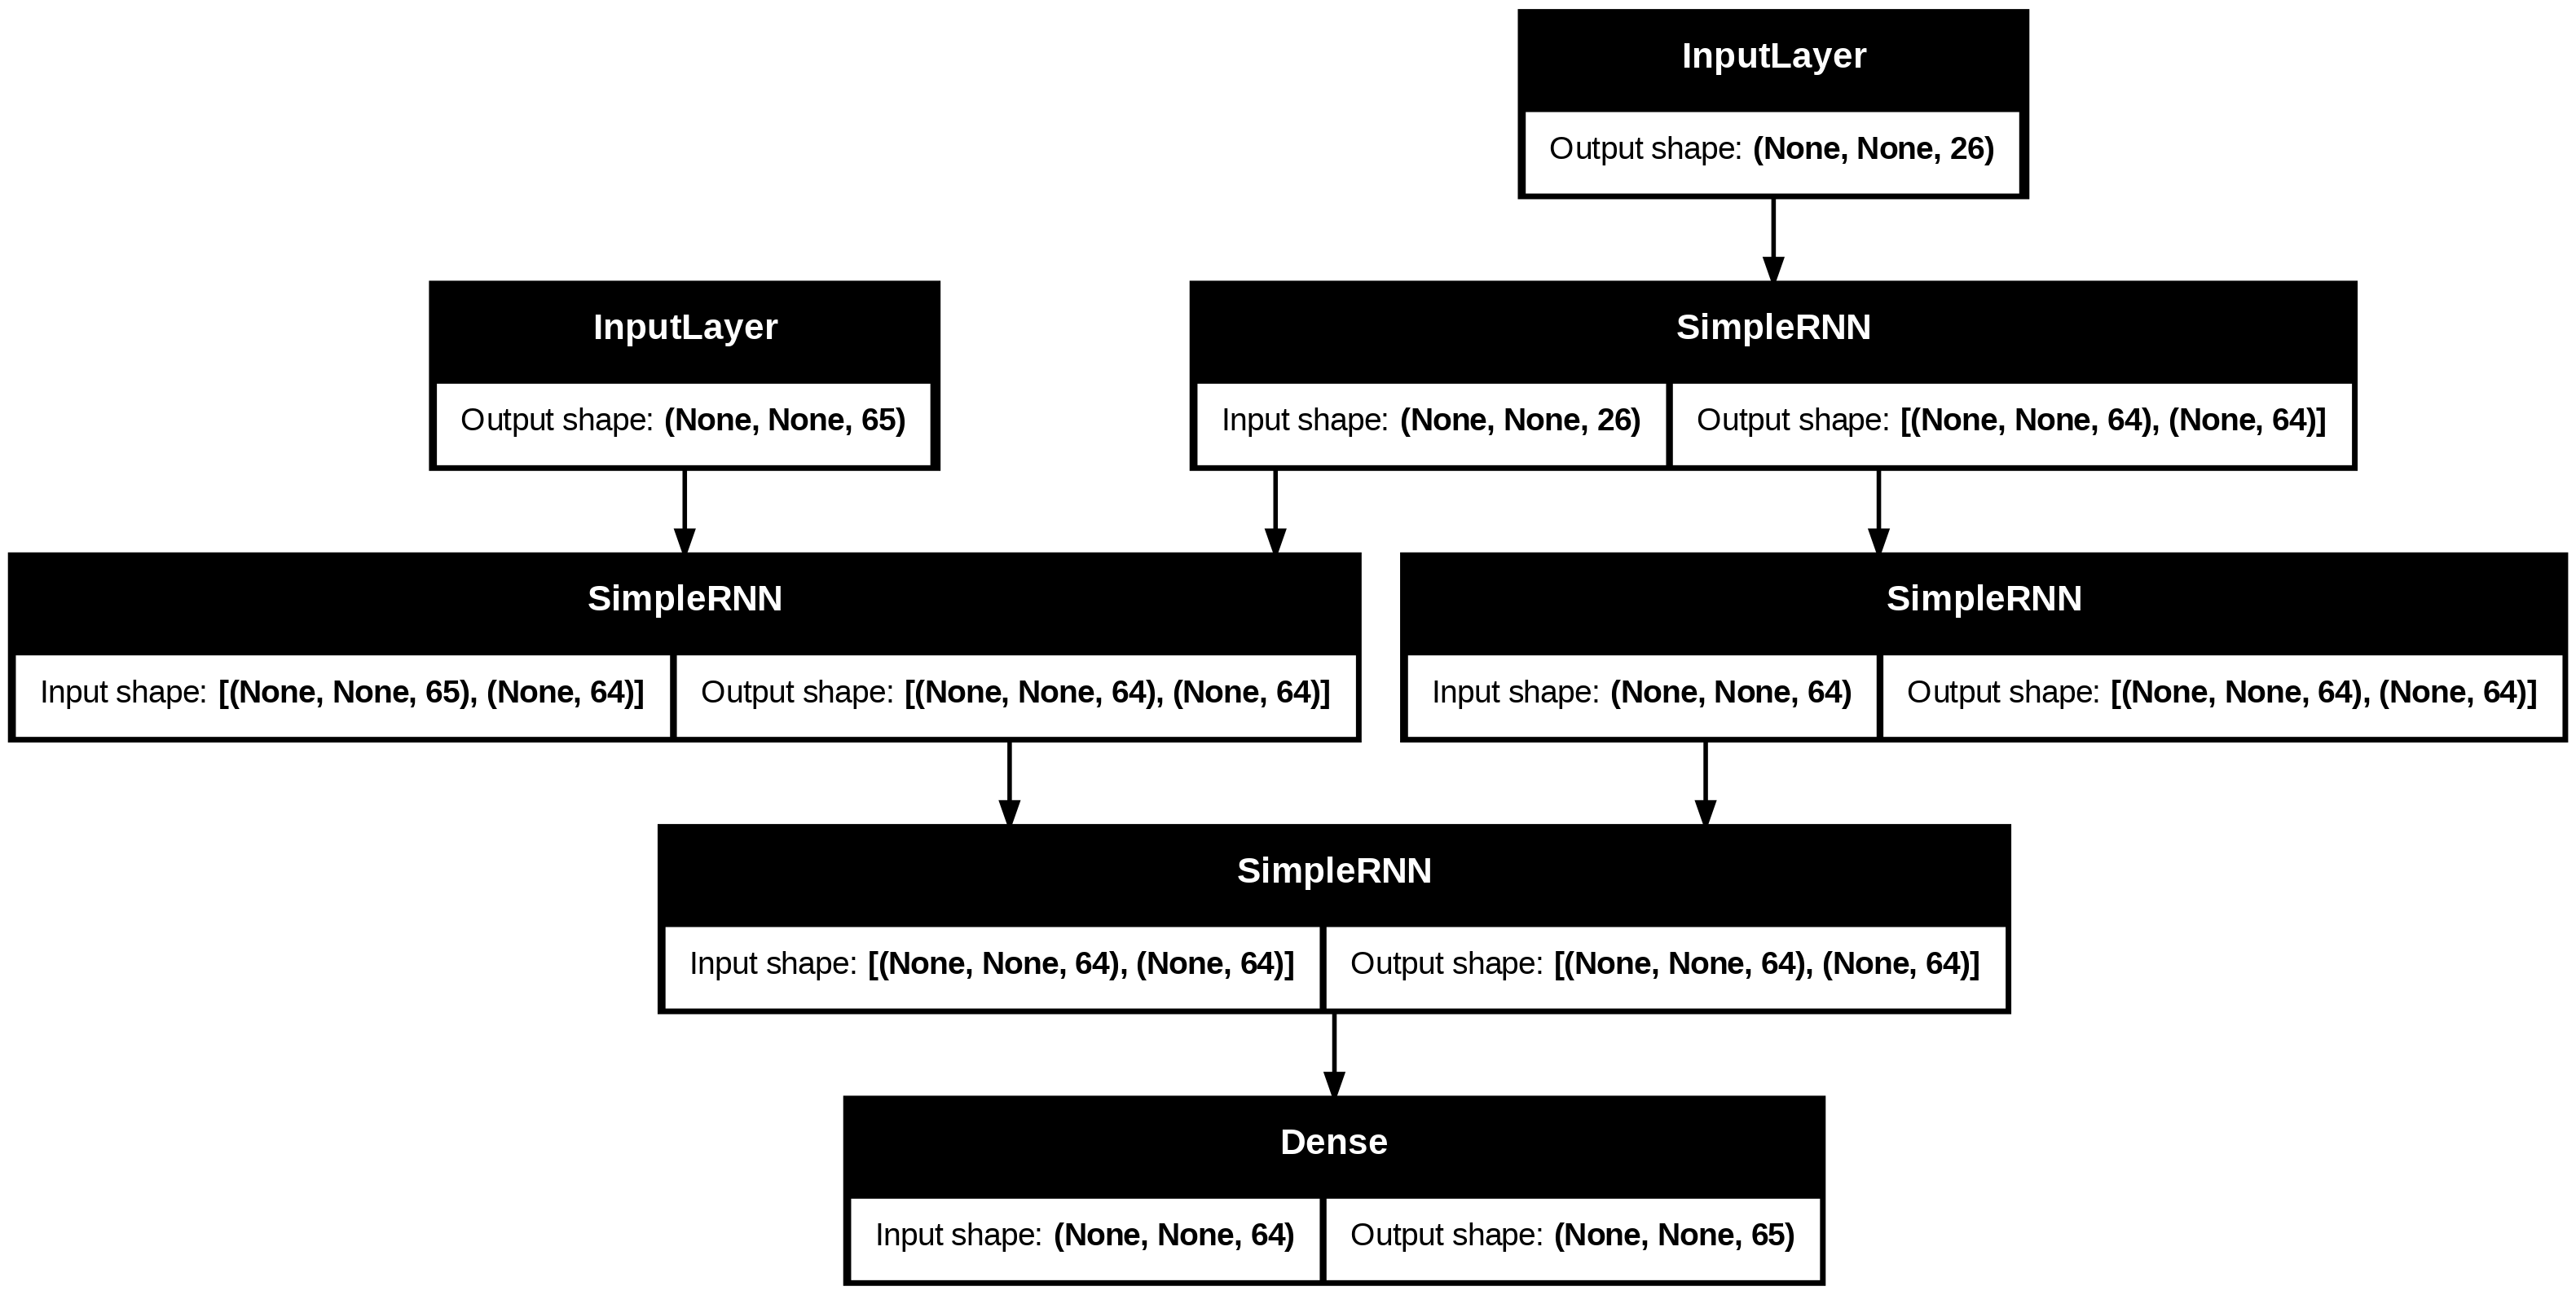

In [ ]:
plot_model(rnn.model, show_shapes=True)

In [53]:
#save the model

rnn.model.save('/content/drive/MyDrive/rnn_model.keras')
